# Base agents for recommendation

In [42]:
from dotenv import load_dotenv

load_dotenv()

True

In [43]:
import pandas as pd
import numpy as np
import random

# fix seeds
random.seed(42)
np.random.seed(42)

## Load data

In [44]:
data = pd.read_csv("../data/cd_and_vinyl/dense_subset.csv")
data_items = pd.read_json("../data/cd_and_vinyl/meta_CDs_and_Vinyl.jsonl", lines=True)

## Sample User and Items

In [45]:
sample_user = (
    data.query(f"user_id == '{data.sample(1, random_state=42)['user_id'].values[0]}'")
    .drop_duplicates()
    .drop(columns=["images", "helpful_vote", "verified_purchase"])
)

In [46]:
items_user = data_items.query("parent_asin in @sample_user['parent_asin'].values").drop(
    columns=["features", "images", "videos", "bought_together", "subtitle", "author"]
)

## Agents

In [47]:
# from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# ollama = ChatOllama(model="phi3:3.8b")
openai = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

In [48]:
# Train / Test
liked_items_train = sample_user.query("rating > 3")
liked_items_train = liked_items_train.sample(2, random_state=42)
liked_items_test = liked_items_train.drop(liked_items_train.index)

disliked_items = sample_user.query("rating < 3")
disliked_items_train = disliked_items.sample(2, random_state=42)
disliked_items_test = disliked_items.drop(disliked_items_train.index)

In [49]:
liked_items_train = liked_items_train.merge(items_user, on="parent_asin")
liked_items_test = liked_items_test.merge(items_user, on="parent_asin")

disliked_items_train = disliked_items_train.merge(items_user, on="parent_asin")
disliked_items_test = disliked_items_test.merge(items_user, on="parent_asin")

In [50]:
liked_items_train

,rating,title_x,text,asin,parent_asin,user_id,timestamp,main_category,title_y,average_rating,rating_number,description,price,store,categories,details
0,4.0,Rock ON!!!!!!!,Disturbed is a really disturbed band .... sort...,B00004R7NE,B00004R7NE,AHJSRXRPCML3OL234YKMWG7KCWHQ,1094703710000,Digital Music,The Sickness,4.8,1650,"[A Chicago metal quartet, Disturbed has been d...",9.75,Disturbed Format: Audio CD,"[CDs & Vinyl, Metal, Alternative Metal]","{'Is Discontinued By Manufacturer': 'No', 'Lan..."
1,5.0,Awesome!!! saw em,I love Megadeth i saw them in concert with som...,B0002SPQ1I,B0002SPQ1I,AHJSRXRPCML3OL234YKMWG7KCWHQ,1099328870000,Digital Music,The System Has Failed,4.7,835,"[Review, ""...raking riffs recapture the spider...",11.0,Megadeth Format: Audio CD,"[CDs & Vinyl, Rock, Progressive, Progressive M...","{'Is Discontinued By Manufacturer': 'No', 'Lan..."


In [51]:
disliked_items_train

,rating,title_x,text,asin,parent_asin,user_id,timestamp,main_category,title_y,average_rating,rating_number,description,price,store,categories,details
0,1.0,"Why can't real, good musicians make as much as...",Its a shame that every real musician that make...,B0007P3582,B0007P3582,AHJSRXRPCML3OL234YKMWG7KCWHQ,1111444785000,Digital Music,The Massacre Explicit Lyrics,4.5,1493,"[Product Description, 50 Cent's highly anticip...",10.98,50 Cent Format: Audio CD,"[CDs & Vinyl, Rap & Hip-Hop, East Coast]","{'Is Discontinued By Manufacturer': 'No', 'Pac..."
1,2.0,Slut...................,She has become such a skank that no one even n...,B00065JTB0,B00065JTB0,AHJSRXRPCML3OL234YKMWG7KCWHQ,1104101842000,Digital Music,Speak,4.5,524,"[Product Description, HAVING ALREADY HAD PRIOR...",21.86,Lindsay Lohan Format: Audio CD,"[CDs & Vinyl, Pop, Teen Pop]","{'Is Discontinued By Manufacturer': 'No', 'Lan..."


In [52]:
# from langchain_core.prompts import PromptTemplate

PROMPT_USER_ITEM = """
Item: {title_item}
Item category: {item_category}
Description: {description}
Price: ${price}
Store: {store}
Categories: {categories}
User rating: {rating}
User comment title: {title_comment}
User comment: {text_comment}
"""

PROMPT_ITEM = """
Item: {title_item}
Item category: {item_category}
Description: {description}
Price: ${price}
Store: {store}
Categories: {categories}
"""


def encode_item(item):
    title_item = item["title_y"]
    item_category = item["main_category"]
    description = " ".join(item["description"])
    price = item["price"]
    store = item["store"]
    categories = item["categories"]

    return {
        "title_item": title_item,
        "item_category": item_category,
        "description": description,
        "price": price,
        "store": store,
        "categories": categories,
    }


def encode_item_format(item):
    item_info = encode_item(item)

    return PROMPT_ITEM.format(
        title_item=item_info["title_item"],
        item_category=item_info["item_category"],
        description=item_info["description"],
        price=item_info["price"],
        store=item_info["store"],
        categories=item_info["categories"],
    )


def encode_user(user):
    title_comment = user["title_x"]
    text_comment = user["text"]
    rating = user["rating"]

    return {
        "title_comment": title_comment,
        "text_comment": text_comment,
        "rating": rating,
    }


def encode_item_user_format(item_user):
    item_info = encode_item(item_user)
    user_info = encode_user(item_user)

    return PROMPT_USER_ITEM.format(
        title_item=item_info["title_item"],
        item_category=item_info["item_category"],
        description=item_info["description"],
        price=item_info["price"],
        store=item_info["store"],
        categories=item_info["categories"],
        rating=user_info["rating"],
        title_comment=user_info["title_comment"],
        text_comment=user_info["text_comment"],
    )

In [53]:
liked_items_train["encoded_item_user"] = liked_items_train.apply(
    encode_item_user_format, axis=1
)
disliked_items_train["encoded_item_user"] = disliked_items_train.apply(
    encode_item_user_format, axis=1
)

liked_items_test["encoded_item"] = liked_items_test.apply(encode_item_format, axis=1)
disliked_items_test["encoded_item"] = disliked_items_test.apply(
    encode_item_format, axis=1
)

In [54]:
liked_items_train_formatted = "\n".join(
    [
        f"ITEM {i}:{item}"
        for i, item in list(enumerate(liked_items_train["encoded_item_user"].values))
    ]
)

disliked_items_train_formatted = "\n".join(
    [
        f"ITEM {i}:{item}"
        for i, item in list(enumerate(disliked_items_train["encoded_item_user"].values))
    ]
)

In [55]:
print(liked_items_train_formatted)

ITEM 0:
Item: The Sickness
Item category: Digital Music
Description: A Chicago metal quartet, Disturbed has been driving fans in the Midwest wild with their frenetic, theatrical live show. On their debut album, The Sickness, the band combines an over-the-top metal groove appealing to the underground with radio-friendly melodic hooks that grab hold of mainstream rock fans. Disturbed is that rare hard group with street credibility and musical chops. Now that is truly disturbing. Certified Multi-Platinum (2 times) by the RIAA. (2/01)
Price: $9.75
Store: Disturbed   Format: Audio CD
Categories: ['CDs & Vinyl', 'Metal', 'Alternative Metal']
User rating: 4.0
User comment title: Rock ON!!!!!!!
User comment: Disturbed is a really disturbed band .... sort of.... Their songs are really melodic and have very brutal and strange lyrics. Their guitars are pounding with awesome riffs. All of their songs are strangly rock'n and asskick'n. Disturbed rocks

ITEM 1:
Item: The System Has Failed
Item categ

In [56]:
print(disliked_items_train_formatted)

ITEM 0:
Item: The Massacre       Explicit Lyrics
Item category: Digital Music
Description: Product Description 50 Cent's highly anticipated follow-up to 'Get Rich Or DieTryin' features production by Dr. Dre and guest shots by Eminem, Lloyd Banks, and many more The first single 'Candy Shop' has been getting major radio airplay as well as 'Disco Inferno'. Aftermath. 2005. Amazon.com 50 Cent is now a full two dollars, according to pop culture exchange rates. His sheer influence on music charts, and thugs hearts, changed things. So why then on Massacre is the 'hood drama that one would think he'd want to leave behind even more front-and-center than on Get Rich or Die Tryin' ? It's hard to say, but 50's developed a questionable gun fetish here. With firearms plastered all over the liner notes, and throughout most of his lyrics--on "In My Hood" he retorts "I don't go nowhere without my strap"--apparently his nouveau rich status has only accelerated the number of enemies he's accumulated. On

In [75]:
from pydantic import BaseModel


class Answer(BaseModel):
    explanation: str
    score: int


PROMPT_USER = """ 
You are a user in a marketplace. Given the following context about items you have interacted with, consider your score to predict if you like or dislike the new itens.
Your answer will be an JSON with two fields: 'explanation' and 'score'. explanation will be a concise rationale about your decision and score will be a integer from 1 to 5, where 1 is dislike and 5 is like.
Don't assume anything about the user that can't be inferred from the context.
Items who you liked:
{liked_items}

Items who you disliked:
{disliked_items}

New item:
{new_items}

Answer:
"""

prompt = PROMPT_USER.format(
    liked_items=liked_items_train_formatted,
    disliked_items=disliked_items_train_formatted,
    new_items=disliked_items_test["encoded_item"].values[0],
)

## Inference

In [76]:
import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")

len(tokenizer.encode(prompt))

2512

In [77]:
structured_llm = openai.with_structured_output(Answer, method="json_mode")
answer = structured_llm.invoke(prompt)

In [78]:
print("Explanation:", answer.explanation)
print("Score:", answer.score)

Explanation: Based on your previous interactions, you have shown a strong preference for heavy metal and hard rock music, as evidenced by your positive ratings for Disturbed and Megadeth. Nickelback, while popular, is often viewed as more mainstream and less heavy than the bands you liked. Given your dislike for rap and pop music, it's likely that you may not appreciate Nickelback's sound as much as the heavier genres you prefer.
Score: 2


## Evaluation

Evaluation comparasion with sample x no sample

In [96]:
from typing import List

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# warning level
import warnings

warnings.filterwarnings("ignore")


def compute_metrics(y_true: List[int], y_pred: List[int]):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mae": mae,
        "mse": mse,
    }

### With sample

In [102]:
prompts_test_negative = [
    PROMPT_USER.format(
        liked_items=liked_items_train_formatted,
        disliked_items=disliked_items_train_formatted,
        new_items=item,
    )
    for item in disliked_items_test["encoded_item"].values
]

prompts_test_positive = [
    PROMPT_USER.format(
        liked_items=liked_items_train_formatted,
        disliked_items=disliked_items_train_formatted,
        new_items=item,
    )
    for item in liked_items_test["encoded_item"].values
]

answers_positive = structured_llm.batch(prompts_test_positive)
answers_negative = structured_llm.batch(prompts_test_negative)

y_pred = [answer.score for answer in answers_positive] + [
    answer.score for answer in answers_negative
]
y_true = liked_items_test["rating"].tolist() + disliked_items_test["rating"].tolist()

metrics_sample = compute_metrics(y_true, y_pred)

metrics_sample

{'accuracy': 0.6666666666666666,
 'precision': 0.5,
 'recall': 0.6666666666666666,
 'f1': 0.5555555555555555,
 'mae': 0.3333333333333333,
 'mse': 0.3333333333333333}

### No sample

In [103]:
prompts_test_negative = [
    PROMPT_USER.format(
        liked_items="No information available about this user.",
        disliked_items="No information available about this user.",
        new_items=item,
    )
    for item in disliked_items_test["encoded_item"].values
]

prompts_test_positive = [
    PROMPT_USER.format(
        liked_items="No information available about this user.",
        disliked_items="No information available about this user.",
        new_items=item,
    )
    for item in liked_items_test["encoded_item"].values
]

answers_positive = structured_llm.batch(prompts_test_positive)
answers_negative = structured_llm.batch(prompts_test_negative)

y_pred = [answer.score for answer in answers_positive] + [
    answer.score for answer in answers_negative
]
y_true = liked_items_test["rating"].tolist() + disliked_items_test["rating"].tolist()

metrics_no_sample = compute_metrics(y_true, y_pred)

metrics_no_sample

{'accuracy': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'mae': 1.3333333333333333,
 'mse': 2.0}

## Generate Graphic

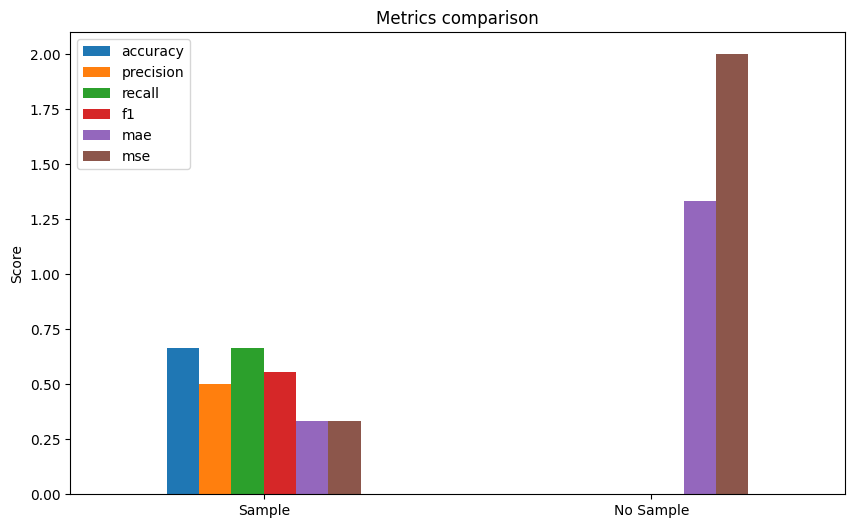

In [106]:
import matplotlib.pyplot as plt

metrics = pd.DataFrame(
    [metrics_sample, metrics_no_sample],
    index=["Sample", "No Sample"],
)

metrics.plot(kind="bar", figsize=(10, 6))
# y rotation
plt.xticks(rotation=0)
plt.title("Metrics comparison")
plt.ylabel("Score")
plt.show()